# Preprocesamiento

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats.stats as st
from __future__ import division

pc_name='nico'
 
def getInverse(arreglo):
    salida = []
    for elemento in arreglo:
        try:
            salida.append([1/elemento])
        except ZeroDivisionError:
            print "error"
    
    return salida

def Beyond1std(arreglo, weigth_mean, standar_dev):
    numerator = 0
    denominator = len(arreglo)
    for elemento in arreglo:
        if abs(elemento-weigth_mean) >= standar_dev:
            numerator += 1
    return numerator/denominator

def slope_trend(arreglo):
    N = len(arreglo) - 1
    for i in range(N):
        num = 0
        if (arreglo[i+1]-arreglo[i]) >= 0:
            num += 1
        
    return num/N  
    
#### directory debe terminar en "/", o filename empezar en "/"
def features (directory, filename):  
    date, Red_m_0 , Red_err_0 , Blue_m_0 , Blue_err_0 = np.loadtxt(directory+filename+'.time', usecols=(0, 1, 2, 3, 4), unpack=True)
    period = np.genfromtxt(directory+filename+'.dat')
    label = ID_labels [filename]
    
    
    ### Eliminar spikes
    ### RED
    index_R = Red_m_0 < 99.999
    Date_red = date[index_R]
    Red_m = Red_m_0[index_R]
    Red_err = Red_err_0[index_R]
    
    ### BLUE 
    index_B = Blue_m_0 < 99.999
    Date_blue = date[index_B]
    Blue_m = Blue_m_0[index_B]
    Blue_err = Blue_err_0[index_B]
    

    ### Features
    Red_len = len(Red_m)
    Blue_len = len(Blue_m)
    
    ### Promedios
    Red_mean = np.mean(Red_m)
    Blue_mean = np.mean(Blue_m)

    ###Standar Deviation
    Red_std = np.std(Red_m)
    Blue_std = np.std(Blue_m)
    

    ### Magnitude Ratio
    max_R = max(Red_m)
    min_R = min(Red_m)
    Red_MagRatio = (max_R - np.median(Red_m))/(max_R - min_R)

    max_B = max(Blue_m)
    min_B = min(Blue_m)
    Blue_MagRatio = (max_B - np.median(Blue_m))/(max_B - min_B)

    ### Amplitud
    Red_amplitude = (max_R - min_R)*0.5
    Blue_amplitude = (max_B - min_B)*0.5
    
    ### Skew
    Red_skew = st.skew(Red_m)
    Blue_skew = st.skew(Blue_m)
    
    ### Eta
    Red_m_square = np.power(Red_m, 2)
    Red_err_square = np.power(Red_err, 2)
    Red_eta = 0
    for j in range(Red_len-1):
        Red_eta += (Red_m_square[j+1]/Red_err_square[j+1])-(Red_m_square[j]/Red_err_square[j])
    
    Red_eta = Red_eta/(Red_len-1)

    
    Blue_m_square = np.power(Blue_m, 2)
    Blue_err_square = np.power(Blue_err, 2)
    Blue_eta = 0
    
    for j in range(Blue_len-1):
        Blue_eta += (Blue_m_square[j+1]/Blue_err_square[j+1])-(Blue_m_square[j]/Blue_err_square[j])
    Blue_eta = Blue_eta/(Blue_len-1)
    
    
    ##Weigthed mean
    #Red_Wmean = np.sum(np.inner(Red_m, getInverse(Red_err_square)))/np.sum(getInverse(Red_err_square))
    #Blue_Wmean = np.sum(np.inner(Blue_m, getInverse(Blue_err_square)))/np.sum(getInverse(Blue_err_square))
    
    ##Beyond1std
    Red_B1std = Beyond1std(Red_m, Red_mean, Red_std)
    Blue_B1std = Beyond1std(Blue_m, Blue_mean, Blue_std)
    
    ##Slope_trend
    Red_slope_trend = slope_trend(Red_m)
    Blue_slope_trend = slope_trend(Blue_m)
    
    ##B-R
    B_R = Blue_mean - Red_mean
    
    return np.array([[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Red_skew, Red_eta, Red_B1std, Red_slope_trend,
                      Blue_mean, Blue_std, Blue_MagRatio, Blue_amplitude, Blue_skew, Blue_eta, Blue_B1std, Blue_slope_trend, B_R, period]])

    #return np.array([[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Red_skew, Red_eta, Red_B1std, Red_slope_trend,
    #                 B_R, period]])


# Diccionario con labels

In [3]:
ID_labels = {}

direccion_ceph = 'CEPH_catalog_crossmatch_eros_ogle.csv'
etiquetas_ceph = np.genfromtxt(direccion_ceph, 'string', delimiter=',')

direccion_RRL = 'RRL_catalog_crossmatch_eros_ogle.csv'
etiquetas_RRL = np.genfromtxt(direccion_RRL, 'string', delimiter=',')

direccion_EB = 'EB_catalog_crossmatch_eros_ogle.csv'
etiquetas_EB = np.genfromtxt(direccion_EB, 'string', delimiter=',')

ogle_id_ceph = etiquetas_ceph[1:len(etiquetas_ceph), 1]
labels_ceph = etiquetas_ceph[1:len(etiquetas_ceph), 4]

ogle_id_RRL = etiquetas_RRL[1:len(etiquetas_RRL), 1]
labels_RRL = etiquetas_RRL[1:len(etiquetas_RRL), 4]

ogle_id_EB = etiquetas_EB[1:len(etiquetas_EB), 1]
labels_EB = etiquetas_EB[1:len(etiquetas_EB), 4]


for indice in range(len(ogle_id_ceph)):
    ID_labels[ ogle_id_ceph[indice] ] = labels_ceph[indice]
    
for indice in range(len(ogle_id_RRL)):
    ID_labels[ ogle_id_RRL[indice] ] = labels_RRL[indice]

for indice in range(len(ogle_id_EB)):
    ID_labels[ ogle_id_EB[indice] ] = labels_EB[indice]

# Creación de base de datos con características

In [4]:
import os

N_features = 9   ## EN EL FUTURO CONSIDERAR QUE SE DEBE INCLUIR EL LABEL

names = []
row_counter = 0
directory1 = 'dataset/'
stars_not_found = 0

clases = os.listdir(directory1)

#directory2 = directory1+clases[1]+"/"
#subclases = os.listdir(directory2)

for clase in clases:
    directory2 = directory1+clase+"/"
    subclases = os.listdir(directory2)

    for carpeta in subclases:
        directory=directory2+carpeta+"/"
        for name in os.listdir(directory):
            if name.endswith(".time"):
                name_2 = (os.path.splitext(name)[0])
                if row_counter == 0 :
                    features_matrix = features(directory,name_2)
                else:
                    try:
                        features_matrix = np.concatenate((features_matrix, features(directory, name_2)), axis = 0)
                    except (KeyError, IOError) as e:
                        stars_not_found += 1
                row_counter += 1

print "Estrellas no encontradas en el cross-match:"
print stars_not_found

import pickle
pickle.dump( features_matrix , open( "caracteristicas.p", "wb" ) )


Estrellas no encontradas en el cross-match:
1047


# Separabilidad clases (EB, Cefeidas, RR Lyrae)

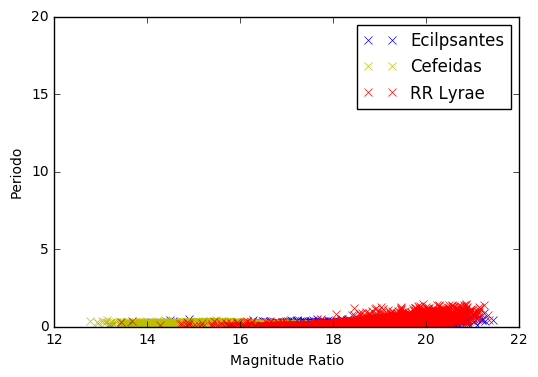

In [5]:
import pickle
caracteristicas = pickle.load( open( "caracteristicas.p", "rb" ) )

feature_1 = 1
feature_2 = 10

RR_feature_1 = []
RR_feature_2 = []

EB_feature_1 = []
EB_feature_2 = []

Ceph_feature_1 = []
Ceph_feature_2 = []

for j in range(len(caracteristicas[:,0])):
    if caracteristicas[j,0][0] == 'R':
        RR_feature_1.append(caracteristicas[j,feature_1])
        RR_feature_2.append(caracteristicas[j,feature_2])

    elif caracteristicas[j,0][0] == 'E':
        EB_feature_1.append(caracteristicas[j,feature_1])
        EB_feature_2.append(caracteristicas[j,feature_2])
    else:
        Ceph_feature_1.append(caracteristicas[j,feature_1])
        Ceph_feature_2.append(caracteristicas[j,feature_2])

        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]

p1, = plt.plot(EB_feature_1, EB_feature_2 , 'x', color='b')
p2, = plt.plot(Ceph_feature_1, Ceph_feature_2 , 'x', color='y') ##g^
p3, = plt.plot(RR_feature_1, RR_feature_2 , 'x', color='r')
plt.axis([12,22, 0, 20])
plt.xlabel("Magnitude Ratio")
plt.ylabel("Periodo")

plt.legend([ p1, p2, p3], ["Ecilpsantes" ,"Cefeidas", "RR Lyrae"])
            

# RR Lyrae Subclases

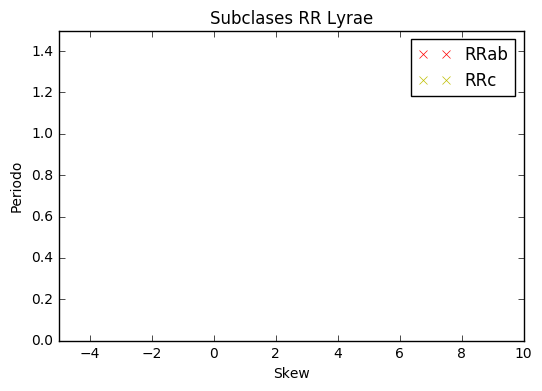

In [6]:
import pickle
caracteristicas = pickle.load( open( "caracteristicas.p", "rb" ) )

feature_1 = 3
feature_2 = 9

RRab_feature_1 = []
RRab_feature_2 = []


RRc_feature_1 = []
RRc_feature_2 = []
counter = 0
RRab= 0
RRc = 0
for j in range(len(caracteristicas[:,0])):
    if caracteristicas[j,0][0] == 'R':
        if caracteristicas[j,0] == "RRab":
            RRab_feature_1.append(caracteristicas[j,feature_1])
            RRab_feature_2.append(caracteristicas[j,feature_2])
            RRab += 1
            
        elif caracteristicas[j,0] == "RRc":
            RRc_feature_1.append(caracteristicas[j,feature_1])
            RRc_feature_2.append(caracteristicas[j,feature_2])
        else:
            counter += 1

ab, = plt.plot(RRab_feature_1, RRab_feature_2 , 'x', color='r')
c, = plt.plot(RRc_feature_1, RRc_feature_2 , 'x', color='y') 
plt.axis([-5,10, 0, 1.5])
plt.xlabel("Skew")
plt.ylabel("Periodo")
plt.legend([ ab, c], ["RRab","RRc"])
plt.title("Subclases RR Lyrae")
        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]
            

In [7]:
subclass = []
for ide in ID_labels:
    label_verify = ID_labels[ide]
    if not (label_verify in subclass):
        subclass.append(label_verify)

RRL_subclases = []
Cefeids_subclases = []
EB_subclases = []

for element in subclass:
    if element[0] == "R":
        RRL_subclases.append(element)   
    elif element[0] == "E":
        EB_subclases.append(element)
    else:
        Cefeids_subclases.append(element)   
        
    

8


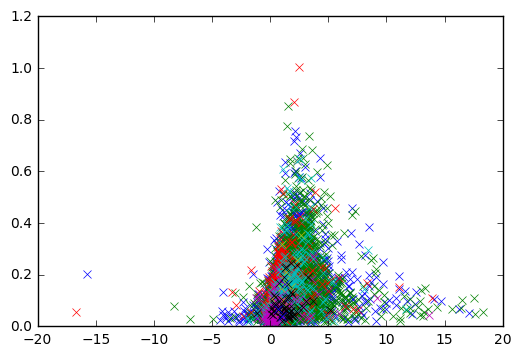

In [8]:
import pickle
caracteristicas = pickle.load( open( "caracteristicas.p", "rb" ) )

def list_of_lists(size):
    new_list=[]
    for i in range(size):
        new_list.append([])
    return new_list

feature_1 = 5
feature_2 = 10 

subclases=EB_subclases
#def sub_class_features(caracteristicas, subclases, feature_1, feature_2):

size_subclases = len(subclases)
subclases_features_2= list_of_lists(size_subclases)
subclases_features_1 = list_of_lists(size_subclases)
c = 0
for j in range(len(caracteristicas[:,0])):
    clase = caracteristicas[j,0]
    if clase in subclases:
        c += 1
        for i in range(len(subclases)):
            if clase == subclases[i]:
                subclases_features_1[i].append(caracteristicas[j,feature_1])
                subclases_features_2[i].append(caracteristicas[j,feature_2])
    
#    return [subclases_features_1, subclases_features_2, c]

print len(subclases_features_1)
#subclases=Cefeids_subclases
#results = sub_class_features(caracteristicas, subclases, feature_1, feature_2)
#print results[2]

ft1 = subclases_features_1
ft2 = subclases_features_2

a, = plt.plot(ft1[0], ft2[0] , 'x')
b, = plt.plot(ft1[1], ft2[1] , 'x')
c, = plt.plot(ft1[2], ft2[2] , 'x')
d, = plt.plot(ft1[3], ft2[3] , 'x')
e, = plt.plot(ft1[4], ft2[4] , 'x')
f, = plt.plot(ft1[5], ft2[5] , 'x')
g, = plt.plot(ft1[6], ft2[6] , 'x')
h, = plt.plot(ft1[7], ft2[7] , 'x')

#plt.axis([0,1, 0, 1.5])

#plt.xlabel("Skew")
#plt.ylabel("Periodo")
#plt.legend([ ab, c], ["RRab","RRc"])
#plt.title("Subclases RR Lyrae")
        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]

# RANDOM FOREST

In [4]:
import pickle
caracteristicas = pickle.load( open( "caracteristicas.p", "rb" ) )


### Codigo para extraer extraer las subclases de cada una de las tres grandes clases ### 
########################################################################################
subclass = []
for ide in ID_labels:
    label_verify = ID_labels[ide]
    if not (label_verify in subclass):
        subclass.append(label_verify)

RRL_subclases = []
Cefeids_subclases = []
EB_subclases = []

for element in subclass:
    if element[0] == "R":
        RRL_subclases.append(element)   
    elif element[0] == "E":
        EB_subclases.append(element)
    else:
        Cefeids_subclases.append(element) 
           
#####  Rearmar las clases de manera que cada una se codifica con un número 0,1 o 2 ##### 
########################################################################################
        
def three_classes(labels_list):
    RRL = 0
    CEFEIDS = 1
    ECLIPSANTES = 2
    
    new_labels = []
    for etiqueta in labels_list:
        if etiqueta in RRL_subclases:
            new_labels.append(RRL)
        elif etiqueta in Cefeids_subclases:
            new_labels.append(CEFEIDS)
        else:
            new_labels.append(ECLIPSANTES)
    return new_labels

only_labels = caracteristicas[:,0]
big_class_labels = three_classes(only_labels)


Feature ranking:
1. feature 17 (0.233352)
2. feature 14 (0.138135)
3. feature 8 (0.095148)
4. feature 12 (0.090243)
5. feature 16 (0.082488)
6. feature 0 (0.077827)
7. feature 6 (0.065020)
8. feature 11 (0.051053)
9. feature 9 (0.046353)
10. feature 3 (0.027561)
11. feature 4 (0.024665)
12. feature 1 (0.016504)
13. feature 10 (0.015813)
14. feature 2 (0.011548)
15. feature 13 (0.009029)
16. feature 5 (0.008280)
17. feature 7 (0.003649)
18. feature 15 (0.003330)


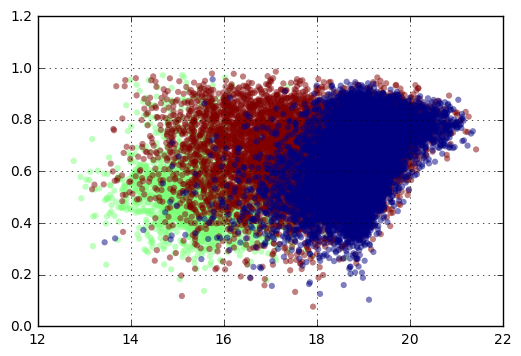

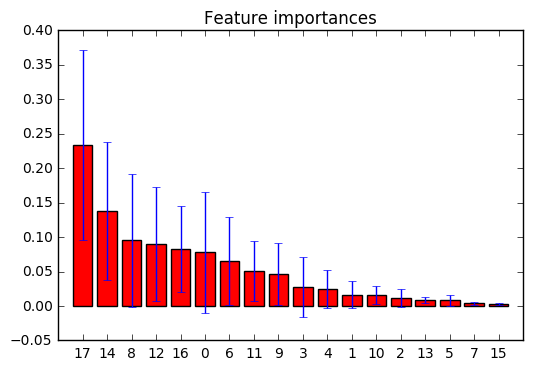

In [52]:

import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

N_features = len(caracteristicas[1,:])
X = caracteristicas[:,1:N_features]
Y = big_class_labels

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 2], c=Y, linewidth=0, alpha=0.5, s=20)
plt.grid()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.25)

clf = RandomForestClassifier(n_estimators=100, max_depth=None, bootstrap = True)
clf = clf.fit(X_train, Y_train)
Y_pred = classifier.predict_proba(X_test)

#scores = cross_val_score(clf, X, Y)
#print "Scores:", scores.mean()



importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


  #  return np.array([[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Red_skew, Red_eta, Red_B1std, Red_slope_trend,
#                  B_R, period]])




In [53]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

def prediction(arreglo):
    n_clases = len(arreglo[0])
    pred = []
    for prediccion in arreglo:
        actual_max = 0
        indice_max = 0
        for i, dato in enumerate(prediccion):
            if dato >= actual_max:
                actual_max = dato
                indice_max = i
        pred.append(indice_max)
    return pred
                



#score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
# training score
#score_train = metrics.f1_score(y_train, pred_train, pos_label=list(set(y_train)))

y_test = Y_test
pred = Y_pred
pred_pscore = prediction(pred)
pscore = metrics.accuracy_score(y_test, pred_pscore)


print pscore
'''
scores = cross_val_score(clf, X_test, Y_test)
print "Scores test:", scores.mean()

scores = cross_val_score(clf, X_train, Y_train)
print "Scores train:", scores.mean()

scores = cross_val_score(clf, X, Y)
print "Scores total:", scores.mean()

path = clf.decision_path(X_train)
'''

0.633561299407


'\nscores = cross_val_score(clf, X_test, Y_test)\nprint "Scores test:", scores.mean()\n\nscores = cross_val_score(clf, X_train, Y_train)\nprint "Scores train:", scores.mean()\n\nscores = cross_val_score(clf, X, Y)\nprint "Scores total:", scores.mean()\n\npath = clf.decision_path(X_train)\n'

In [44]:
print Y_pred[0:10]
print Y_test[0:10]
print pred_pscore[0:200]

[[  5.24600200e-01   1.08450514e-01   3.66949286e-01]
 [  5.24600200e-01   1.08450514e-01   3.66949286e-01]
 [  5.24600200e-01   1.08450514e-01   3.66949286e-01]
 [  9.98507296e-01   6.33502882e-06   1.48636886e-03]
 [  5.24600200e-01   1.08450514e-01   3.66949286e-01]
 [  2.05018796e-01   3.61353378e-01   4.33627826e-01]
 [  5.24600200e-01   1.08450514e-01   3.66949286e-01]
 [  8.34307689e-01   2.56785661e-02   1.40013745e-01]
 [  5.24600202e-01   1.08450513e-01   3.66949285e-01]
 [  9.98504805e-01   6.27915733e-06   1.48891590e-03]]
[0, 0, 2, 0, 2, 2, 2, 0, 0, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2